__Author : Hafidzati Hikmadani <br>
Date   : November 19th 2021__

## Background
Because acquiring new customer is more costly than retain the existing, company needs to prevent customers to leave.

To know what step should company done to prevent increasing churn, we need first to analyze the behaviour of past churn customer history. If we get the pattern, company could start their strategies to treat those potential churn customer based on analysis of data.

1. Behaviour of customer who churn based on existing data?
2. Compare pattern of stayed customer vs churn customer, is there any difference?

## Load Library

In [28]:
#Loading library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold , cross_validate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from pipelinehelper import PipelineHelper
from sklearn.metrics import make_scorer

## Load Dataset

In [29]:
#Load dataset
data = pd.read_csv("Churn_Modelling.csv")

In [30]:
#preview
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [31]:
#shape
print("We have ", data.shape[0], " row and " , data.shape[1] ,"columns")

We have  10000  row and  14 columns


In [32]:
#profile
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Notes :
- There is no wrong data types

## Data Cleaning

In [33]:
#copy dataset
df = data.copy()

In [34]:
#checking missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There is no missing values in dataset.

In [35]:
#checking duplicates values
df.duplicated().sum()

0

There is no duplicated values.

In [36]:
#check unique values / cardinality
for x in df.columns:
    print("Total unique values of", x , ":" ,len(df[x].unique()))
    print(df[x].unique())
    print("")

Total unique values of RowNumber : 10000
[    1     2     3 ...  9998  9999 10000]

Total unique values of CustomerId : 10000
[15634602 15647311 15619304 ... 15584532 15682355 15628319]

Total unique values of Surname : 2932
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Total unique values of CreditScore : 460
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 54

Nothing is weird in every unique values. We could see RowNumber, customerID and surename has really high cardinality which won't be used for our model in future.

## Data Visualization

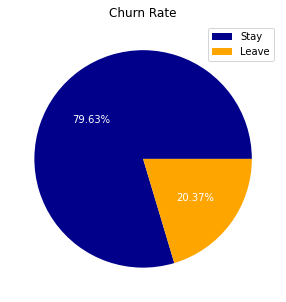

In [37]:
#Graph
q1 = df.groupby("Exited")["CustomerId"].count().reset_index()
plt.figure(figsize=(5,5))
plt.pie(q1["CustomerId"], autopct="%.2f%%",labels=["Stay", "Leave"], colors=["darkblue","orange"],textprops={'color':"w"})
plt.title('Churn Rate')
plt.legend()

plt.show()

Based on https://www.reviewtrackers.com/blog/bank-customer-retention/ , the average customer attrition rate among retail financial institutions per year is 15%. 

If we assume this data is belonging to bank/ financial company. The churn rate are high because it hits 20% , above the average industry.

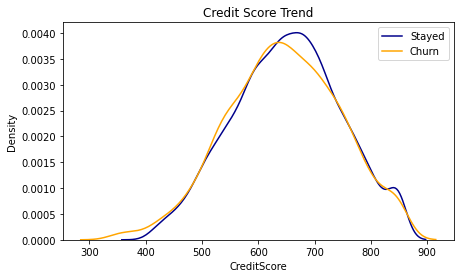

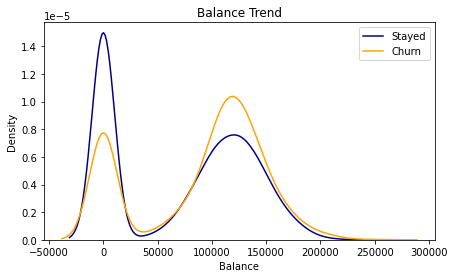

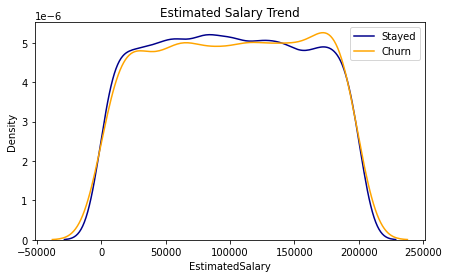

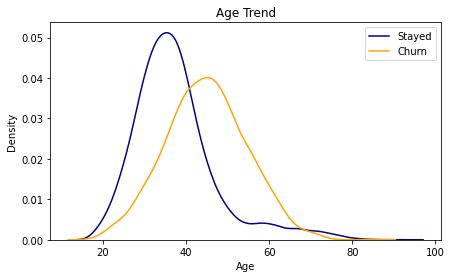

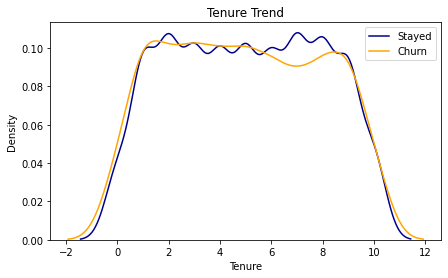

In [38]:
#Query
df_churn = df[df["Exited"] == 1]
df_stay = df[df["Exited"] == 0]

#Graph
plt.figure(figsize=(7,4))
sns.kdeplot(df_stay["CreditScore"], label="Stayed" ,color="darkblue")
sns.kdeplot(df_churn["CreditScore"], label="Churn",color="orange")
plt.legend()
plt.title("Credit Score Trend")
plt.show()

#Graph
plt.figure(figsize=(7,4))
sns.kdeplot(df_stay["Balance"], label="Stayed",color="darkblue")
sns.kdeplot(df_churn["Balance"], label="Churn",color="orange")
plt.legend()
plt.title("Balance Trend")
plt.show()

#Graph
plt.figure(figsize=(7,4))
sns.kdeplot(df_stay["EstimatedSalary"], label="Stayed",color="darkblue")
sns.kdeplot(df_churn["EstimatedSalary"], label="Churn",color="orange")
plt.legend()
plt.title("Estimated Salary Trend")
plt.show()

#Graph
plt.figure(figsize=(7,4))
sns.kdeplot(df_stay["Age"], label="Stayed",color="darkblue")
sns.kdeplot(df_churn["Age"], label="Churn",color="orange")
plt.legend()
plt.title("Age Trend")
plt.show()

#Graph
plt.figure(figsize=(7,4))
sns.kdeplot(df_stay["Tenure"], label="Stayed",color="darkblue")
sns.kdeplot(df_churn["Tenure"], label="Churn",color="orange")
plt.legend()
plt.title("Tenure Trend")
plt.show()

From above plot, we could compare stayed vs churn customer based on each attributes. Tenure and Estimated Salary pattern between stayed and churn customer has similar curved , means tenure and estimated might not have effect to churn customer.

But looking at the rest attributes, the curve/pattern has a bit difference :
- In credit score, mostly churn customer has credit score 620 - 650. It's surprising since that is part of good credit score. It means, customer with good credit score has high chance to churn.
- In age , we could see churn customer typically are in age 40 - 55. This might because at those range , people tend to stopping their interest to bank/ finance since they are near to retirement. Company might need to make some program for retirement plan so those customer might change their mind to churn.
- In balance, the most churn customer are customer who has balance around 100k - 150k than stayed customer. This might happened, at this point of balance customer are in a standard balance and they tend to find out another beneficial competitor for their standard balance. So to retain this kind of customer, company might need to create special program

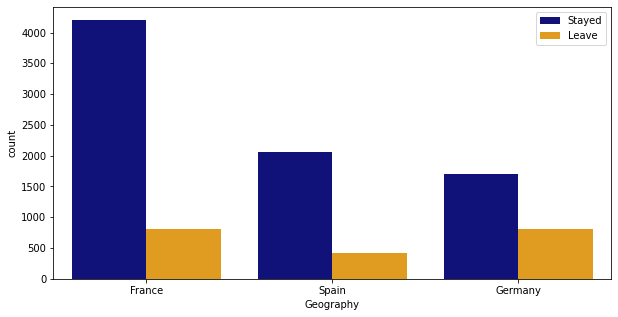

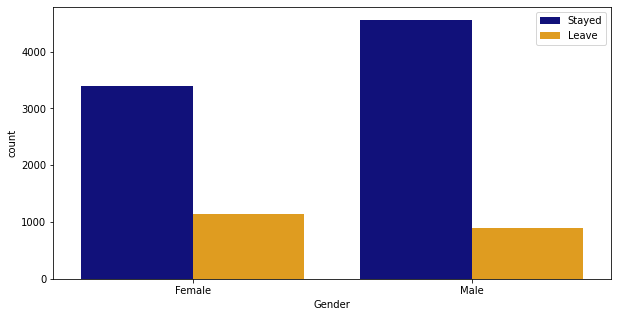

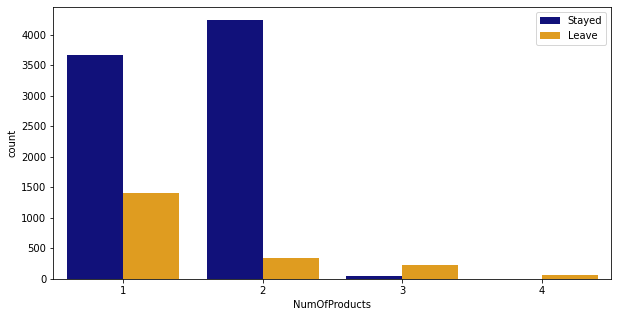

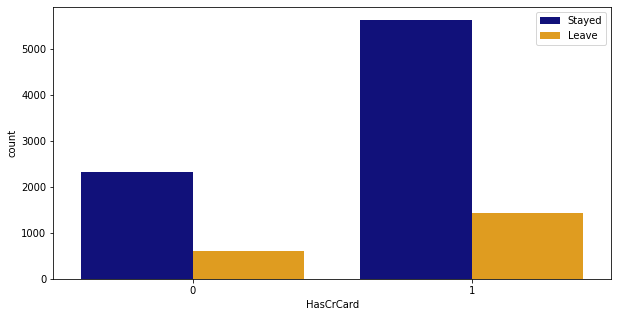

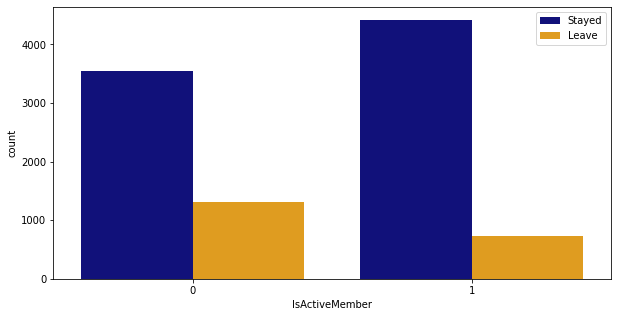

In [39]:
#Graph
plt.figure(figsize=(10,5))
sns.countplot(x="Geography",  hue="Exited", data =df, palette=["darkblue","orange"])
plt.legend(labels=["Stayed","Leave"])
plt.show()

#Graph
plt.figure(figsize=(10,5))
sns.countplot(x="Gender", hue="Exited", data =df, palette=["darkblue","orange"])
plt.legend(labels=["Stayed","Leave"])
plt.show()

#Graph
plt.figure(figsize=(10,5))
sns.countplot(x="NumOfProducts",  hue="Exited", data =df, palette=["darkblue","orange"])
plt.legend(labels=["Stayed","Leave"] , loc="upper right")
plt.show()

#Graph
plt.figure(figsize=(10,5))
sns.countplot(x="HasCrCard", hue="Exited", data =df, palette=["darkblue","orange"])
plt.legend( labels=["Stayed","Leave"], loc="upper right")
plt.show()

#Graph
plt.figure(figsize=(10,5))
sns.countplot(x="IsActiveMember", hue="Exited", data =df, palette=["darkblue","orange"])
plt.legend(labels=["Stayed","Leave"])
plt.show()

Relate to our previous composition of churn vs stayed customer, we have higher propotion of stayed customer than the churn. If above attributes doesn't impact the churn customer, the propotion of each attributes classes might has some propotion. But we found some interesting result , such as :
- Germany has highest churn rate.
- Female most likely to churn than male.
- Non-active member are likely to churn.
- Num of products 1 has high churn rate, but num of products 2,3,4 has very low total customer.

From above insight, some suggestion for company might could help :
- Investigae germany customer and create special program for them.
- Create special program for female.
- Give more offer or some extra treatment (such as active approach) for non-active member so they could be active again and retained.
- Considering product 2,3,4 and evaluate it again.

## Feature Selection

In feature selection, we would use Chi-Square and ANNOVA approach to know relationship between features and its target.

__Hyphotesis__ <br>
H0: The attribute sex has no role to play in the survival of a passenger ( The feature is not important)<br>
H1: The attribute sex has a role to play in survival (The feature is important)<br>

Significance value : 0.05

In [40]:
## Check categorical correlation with target

cat_en = LabelEncoder()
df_cat = pd.DataFrame()

for i in ["Geography","Gender","NumOfProducts","HasCrCard","IsActiveMember"]:
    df_cat[i]= cat_en.fit_transform(df[i])

#define feature selection generator
fs_cat = SelectKBest(score_func=chi2, k =2)

#apply categorical feature and target 
X_feat_cat = fs_cat.fit(df_cat, df["Exited"])

chi = pd.DataFrame({"att":df_cat.columns, "chi-square":X_feat_cat.scores_, "pvalue": np.round(X_feat_cat.pvalues_ , 5)})
chi





,att,chi-square,pvalue
0,Geography,11.853251,0.00058
1,Gender,51.539926,0.00000
2,NumOfProducts,14.590276,0.00013
3,HasCrCard,0.150041,0.69850
4,IsActiveMember,118.199414,0.00000


In [41]:
num_en = MinMaxScaler()
df_num = num_en.fit_transform(df[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])

#define feature selection generator
fs_num = SelectKBest(score_func=f_classif ,k ="all")

#apply categorical feature and target 
X_feat_num = fs_num.fit(df_num, df["Exited"])

anv = pd.DataFrame({"att":["CreditScore","Age","Tenure","Balance","EstimatedSalary"], 
"annova":X_feat_num.scores_, "pvalue": np.round(X_feat_num.pvalues_ , 5)})
anv

,att,annova,pvalue
0,CreditScore,7.344522,0.00674
1,Age,886.063275,0.00000
2,Tenure,1.960164,0.16153
3,Balance,142.473832,0.00000
4,EstimatedSalary,1.463262,0.22644


From above table, we got several features which has p-value < 0.05 , such as :
- CreditScore
- Geography
- Gender
- Age
- Balance
- NumOfProducts
- IsActiveMember

## Data PreProcess

In [42]:
X = df[["CreditScore","Geography","Gender","Age","Balance","NumOfProducts","IsActiveMember"]]
y = df["Exited"]

In [43]:
#split dataset
X_train, X_dataset, y_train, y_dataset = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= True, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_dataset, y_dataset, test_size=0.5, random_state=42, shuffle= True, stratify=y_dataset)

print("Total of training data   : ", X_train.shape[0])
print("Total of validation data : ", X_valid.shape[0])
print("Total of testing  data   : ", X_test.shape[0])

Total of training data   :  8000
Total of validation data :  1000
Total of testing  data   :  1000


In [44]:
#normalize validation dataset
num_norm = MinMaxScaler()
cat_norm = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)

df_num = X_train[["CreditScore","Age","Balance"]]
df_cat = X_train[["Geography","Gender","NumOfProducts","IsActiveMember"]]

df_nums = num_norm.fit_transform(df_num)
df_cats = cat_norm.fit_transform(df_cat)

X_trains = np.concatenate((df_nums, df_cats), axis=1)
y_trains = np.array(y_train)


In [46]:
#normalize validation dataset
df_num = X_valid[["CreditScore","Age","Balance"]]
df_cat = X_valid[["Geography","Gender","NumOfProducts","IsActiveMember"]]

df_nums = num_norm.transform(df_num)
df_cats = cat_norm.transform(df_cat)

X_valids = np.concatenate((df_nums, df_cats), axis=1)
y_valids = np.array(y_valid)

## Modeling

In this modeling we will compare some algorithm to get best model :
- Logistic Regression with SMOTE
- Logistic Regression without SMOTE
- RandomForest with SMOTE
- RandomForest without SMOTE

Notes: SMOTE are technique to handle imabalance dataset since we had imbalance churn customer.

__Without SMOTE__

In [47]:
#Full pipeline
pipeline_imb = Pipeline(steps=[
    ["Classifier", PipelineHelper([
        ("Logistic", LogisticRegression(random_state=42)),
        ("RandomForest", RandomForestClassifier(random_state=42))
    ])]
])

#Define Parameter
param= {
    'Classifier__selected_model': pipeline_imb.named_steps["Classifier"].generate({
    'Logistic__C': [500,1000],
    'Logistic__solver':["lbfgs","liblinear"],
    'Logistic__max_iter' : [1000,1500],
    'RandomForest__max_depth': [6,8],
    'RandomForest__n_estimators' : [10,15],
    'RandomForest__max_features': [5,7],
    'RandomForest__min_samples_split': [1000, 1200]
    })
}

#make scorer
scoring = {'F1': "f1","AUC":"roc_auc","Accuracy":"accuracy","Precision":"precision","Recall":"recall"}

#define cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

grid_imbalanced= GridSearchCV(pipeline_imb, param_grid=param, cv=cv, 
    scoring=scoring, refit="AUC", error_score="raise", return_train_score=True)

In [48]:
#train 
grid_imbalanced.fit(X_trains,y_trains)

#get best param
grid_imbalanced.best_params_

{'Classifier__selected_model': ('RandomForest',
  {'max_depth': 6,
   'max_features': 5,
   'min_samples_split': 1000,
   'n_estimators': 15})}

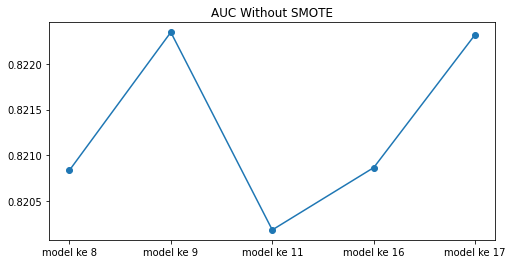

,Rank,mean_test_AUC,mean_test_Accuracy
8,4,0.820833,0.843917
9,1,0.822348,0.844833
11,5,0.820180,0.839375
16,3,0.820863,0.844333
17,2,0.822322,0.844208


In [49]:
#TOP 5 BEST MODEL
imb_eva = pd.DataFrame(grid_imbalanced.cv_results_)
imb_eva = imb_eva[imb_eva["rank_test_AUC"]<6]

#Graph
plt.figure(figsize=(8,4))
plt.plot([str("model ke "+str(x)) for x in imb_eva.index], imb_eva["mean_test_AUC"], marker="o", label="Mean AUC")
# pd.DataFrame(bal_eva[["mean_test_AUC","mean_test_Accuracy"]]).plot(figsize=(15,5), marker='x')
plt.title("AUC Without SMOTE")
plt.show()

imb_eva[["rank_test_AUC","mean_test_AUC","mean_test_Accuracy"]].rename(columns={"rank_test_AUC":"Rank"})

From above training, we have AUC score since we want to have good precision and recall. We got top 5 models . But the best from the best are without SMOTE are Model 9 with mean AUC Score : 0.822348 in rank 1. It has hyperparameter max_depth = 6

Now let's check does model 9 is overfit or underfit or stabil in every iteration.

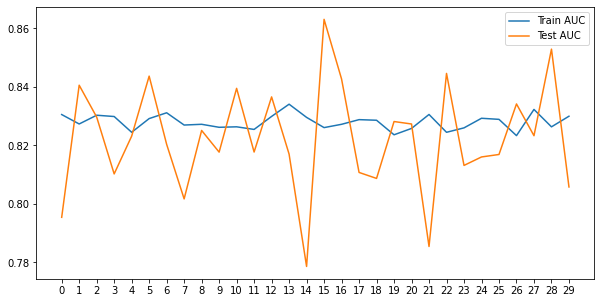

In [51]:
#overfit check
imb_rank1 = imb_eva[imb_eva["rank_test_AUC"] == 1].transpose().reset_index()

test_auc = imb_rank1[imb_rank1["index"].isin([str("split"+str(x)+"_test_AUC") for x in range(30)])]
train_auc = imb_rank1[imb_rank1["index"].isin([str("split"+str(x)+"_train_AUC") for x in range(30)])]

#Graph 
plt.figure(figsize=(10,5))
plt.plot([str(x) for x in range(30)], train_auc[9],  label="Train AUC")
plt.plot([str(x) for x in range(30)], test_auc[9],  label="Test AUC")
plt.legend()
plt.show()



From above graph we could see that RandomForest with max_dept=6 and without SMOTE are still not stabil model eventhough it's the best model from others. From 30 iteration, this model produce random overfit and underfit (represented by orange line).

__With SMOTE__

In [52]:
#Full pipeline
pipeline_bal = imbpipeline(steps=[
    ["smote", SMOTE(random_state=42)],
    ["Classifier", PipelineHelper([
        ("Logistic", LogisticRegression(random_state=42)),
        ("RandomForest", RandomForestClassifier(random_state=42))
    ])]
])

#Define Parameter
param= {
    'Classifier__selected_model': pipeline_bal.named_steps["Classifier"].generate({
    'Logistic__C': [500,1000],
    'Logistic__solver':["lbfgs","liblinear"],
    'Logistic__max_iter' : [1000,1500],
    'RandomForest__max_depth': [6,8],
    'RandomForest__n_estimators' : [10,15],
    'RandomForest__max_features': [5,7],
    'RandomForest__min_samples_split': [1000, 1200]
    })
}

#make scorer
scoring = {'F1': "f1","AUC":"roc_auc","Accuracy":"accuracy","Precision":"precision","Recall":"recall"}

#define cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

grid_balanced= GridSearchCV(pipeline_bal, param_grid=param, cv=cv, 
    scoring=scoring, refit="AUC", error_score="raise", return_train_score=True)

In [53]:
#train 
grid_balanced.fit(X_trains,y_trains)

#get best param
grid_balanced.best_params_

{'Classifier__selected_model': ('RandomForest',
  {'max_depth': 8,
   'max_features': 5,
   'min_samples_split': 1000,
   'n_estimators': 15})}

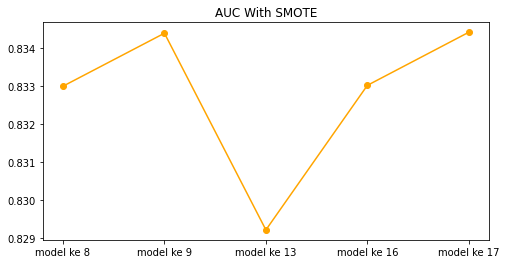

,Rank,mean_test_AUC,mean_test_Accuracy
8,4,0.832991,0.780208
9,2,0.834382,0.782958
13,5,0.829218,0.774000
16,3,0.833013,0.780875
17,1,0.834408,0.783417


In [54]:
#TOP 5 BEST MODEL
bal_eva = pd.DataFrame(grid_balanced.cv_results_)
bal_eva = bal_eva[bal_eva["rank_test_AUC"]<6]

#Graph
plt.figure(figsize=(8,4))
plt.plot([str("model ke "+str(x)) for x in bal_eva.index], bal_eva["mean_test_AUC"], marker="o", label="Mean AUC", color="orange")
# pd.DataFrame(bal_eva[["mean_test_AUC","mean_test_Accuracy"]]).plot(figsize=(15,5), marker='x')
plt.title("AUC With SMOTE")
plt.show()

bal_eva[["rank_test_AUC","mean_test_AUC","mean_test_Accuracy"]].rename(columns={"rank_test_AUC":"Rank"})

From above training, we have AUC score since we want to have good precision and recall. We got top 5 models . But the best from the best are with SMOTE are Model 17 with mean AUC Score :0.834408 in rank 1. It has hyperparameter max_depth = 8

Now let's check does model 9 is overfit or underfit or stabil in every iteration.

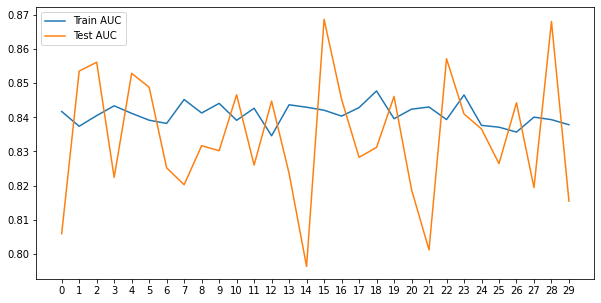

In [55]:
#overfit
bal_rank1 = bal_eva[bal_eva["rank_test_AUC"] == 1].transpose().reset_index()

test_auc = bal_rank1[bal_rank1["index"].isin([str("split"+str(x)+"_test_AUC") for x in range(30)])]
train_auc = bal_rank1[bal_rank1["index"].isin([str("split"+str(x)+"_train_AUC") for x in range(30)])]

#Graph 

#Graph 
plt.figure(figsize=(10,5))
plt.plot([str(x) for x in range(30)], train_auc[17],  label="Train AUC")
plt.plot([str(x) for x in range(30)], test_auc[17],  label="Test AUC")
plt.legend()
plt.show()



From above graph we could see that RandomForest with max_dept=8 and with SMOTE also are not stabil model eventhough it's the best model from others. From 30 iteration, this model produce random overfit and underfit (represented by orange line).

### Evaluation SMOTE VS NOT SMOTE

Now we will compare both best model with smote vs best model widhout smote.

__Without SMOTE__

              precision    recall  f1-score   support

           0       0.88      0.96      0.91       796
           1       0.73      0.47      0.57       204

    accuracy                           0.86      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.85      0.86      0.84      1000

AUC Score :  0.7133091930239432



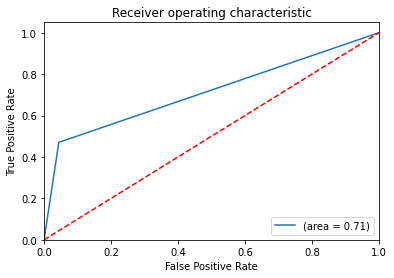

In [58]:
#Another Evaluation
print(classification_report(y_valids, grid_imbalanced.predict(X_valids) ))

#ROC Curve
logit_roc_auc1 = roc_auc_score(y_valids, grid_imbalanced.predict(X_valids))
print("AUC Score : ", logit_roc_auc1)
print("")
fpr1, tpr1, thresholds1 = roc_curve(y_valids, grid_imbalanced.predict(X_valids))
plt.figure()
plt.plot(fpr1, tpr1, label='(area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


__With SMOTE__

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       796
           1       0.52      0.73      0.60       204

    accuracy                           0.81      1000
   macro avg       0.72      0.78      0.74      1000
weighted avg       0.84      0.81      0.82      1000

AUC Score :  0.7760616809537886



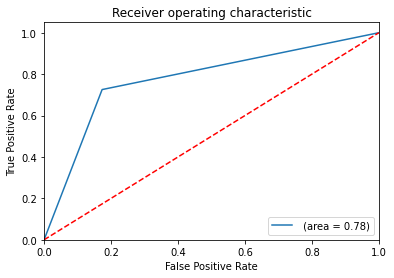

In [59]:
print(classification_report(y_valids, grid_balanced.predict(X_valids)))

#ROC Curve
logit_roc_auc1 = roc_auc_score(y_valids, grid_balanced.predict(X_valids))
print("AUC Score : ", logit_roc_auc1)
print("")
fpr1, tpr1, thresholds1 = roc_curve(y_valids, grid_balanced.predict(X_valids))
plt.figure()
plt.plot(fpr1, tpr1, label=' (area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

At this point, we will focus only on AUC Score, Recall and F1Score. Because we want to have model which has ability not to predict churn customer as not churn that's why we use Recall. But at the second priority we also wants better model to predict true churn customer that's why we use AUC Score and F1Score (harmonic value of precision & recall).

From both graph aboves we could see that RandomForest (Max_dept=8) with SMOTE has better performance with :
- AUC Score = 0,78
- Recall = 0,73
- F1 Score = 0,60

This proves that RandomForest is way better for common problem machine learning and also balanced data are one of good pre-requisite that need to be considered in building model with good performance.

__Input for future research__ <br>
- Collect more dataset
- Try another algorithm such as XGBoosting
